## Ogólny przegląd danych

**[Przygotowanie danych](#Przygotowanie-danych)**
<br>
**[Tworzenie modeli](#Tworzenie-modeli)**
<br>
[KNN](#KNN)
<br>
[RandomForest](#RandomForest)
<br>
[LogisticRegression](#LogisticRegression)
<br>
[SVM](#SVM)
<br>
**[Hiperparametryzacja](#Hiperparametryzacja)**

In [93]:
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, train_test_split
from imblearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, MaxAbsScaler, StandardScaler
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical
from colorama import Fore, Style


import warnings
warnings.filterwarnings("ignore")

Dane dotyczące oszustw na Ethereum

Kolumna FLAG - okresla czy coś jest oszustwem (1) czy nie (0)

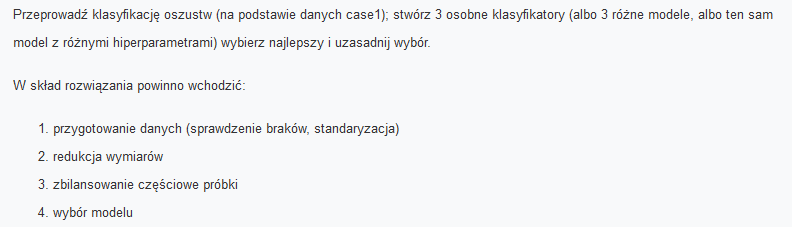

In [51]:
data = pd.read_csv('case1.csv', sep=';')

In [52]:
data.head()

,Unnamed: 0,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,0,1,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,1,2,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,2,3,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,NaN,XENON
3,3,4,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,...,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,4,5,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,...,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS


In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9841 entries, 0 to 9840
Data columns (total 51 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Unnamed: 0                                            9841 non-null   int64  
 1   Index                                                 9841 non-null   int64  
 2   Address                                               9841 non-null   object 
 3   FLAG                                                  9841 non-null   int64  
 4   Avg min between sent tnx                              9841 non-null   float64
 5   Avg min between received tnx                          9841 non-null   float64
 6   Time Diff between first and last (Mins)               9841 non-null   float64
 7   Sent tnx                                              9841 non-null   int64  
 8   Received Tnx                                          9841

In [54]:
# Checking how many of each column contains values equal to 0
results = {}
perc_res = {}

for column in data.columns:
    if data[column].dtype == 'float64':
        count_nans = data[column].isna().sum()
        percentage_results = (count_nans / len(data)) * 100
        results[column] = count_nans
        perc_res[column] = percentage_results

        
'''
red - null cells above 90%
orange -  null cells between 80% and 90%
green -  null cells below 25%

'''

for column, zero_count in results.items():
    percentage = perc_res[column]
    if percentage > 90:
        color = Fore.RED  
    elif percentage > 80:
        color = Fore.YELLOW 
    elif percentage < 25:
        color = Fore.GREEN 
    else:
        color = ''  

    print(f'{color}Column {column} includes {percentage:.2f} % null cells.{Style.RESET_ALL}')

Column Avg min between sent tnx includes 0.00 % null cells.
Column Avg min between received tnx includes 0.00 % null cells.
Column Time Diff between first and last (Mins) includes 0.00 % null cells.
Column min value received includes 0.00 % null cells.
Column max value received  includes 0.00 % null cells.
Column avg val received includes 0.00 % null cells.
Column min val sent includes 0.00 % null cells.
Column max val sent includes 0.00 % null cells.
Column avg val sent includes 0.00 % null cells.
Column min value sent to contract includes 0.00 % null cells.
Column max val sent to contract includes 0.00 % null cells.
Column avg value sent to contract includes 0.00 % null cells.
Column total Ether sent includes 0.00 % null cells.
Column total ether received includes 0.00 % null cells.
Column total ether sent contracts includes 0.00 % null cells.
Column total ether balance includes 0.00 % null cells.
Column Total ERC20 tnxs includes 8.42 % null cells.
Column ERC20 total Ether received i

In [55]:
data.describe().round(3)

,Unnamed: 0,Index,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,...,ERC20 max val rec,ERC20 avg val rec,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name
count,9841.000,9841.000,9841.000,9841.000,9841.000,9841.000,9841.000,9841.000,9841.000,9841.000,...,9.012000e+03,9.012000e+03,9.012000e+03,9.012000e+03,9.012000e+03,9012.0,9012.0,9012.0,9012.000,9012.000
mean,4920.000,1815.050,0.221,5086.879,8004.851,218333.258,115.932,163.701,3.730,30.361,...,1.252524e+08,4.346203e+06,1.174126e+04,1.303594e+07,6.318389e+06,0.0,0.0,0.0,1.385,4.827
std,2840.996,1222.622,0.415,21486.550,23081.715,322937.926,757.226,940.837,141.446,298.621,...,1.053741e+10,2.141192e+08,1.053567e+06,1.179905e+09,5.914764e+08,0.0,0.0,0.0,6.735,16.679
min,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000,0.000
25%,2460.000,821.000,0.000,0.000,0.000,316.930,1.000,1.000,0.000,1.000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000,0.000
50%,4920.000,1641.000,0.000,17.340,509.770,46637.030,3.000,4.000,0.000,2.000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000,1.000
75%,7380.000,2601.000,0.000,565.470,5480.390,304070.980,11.000,27.000,0.000,5.000,...,9.900000e+01,2.946500e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000,2.000
max,9840.000,4729.000,1.000,430287.670,482175.490,1954860.950,10000.000,10000.000,9995.000,9999.000,...,1.000000e+12,1.724181e+10,1.000000e+08,1.120000e+11,5.614756e+10,0.0,0.0,0.0,213.000,737.000


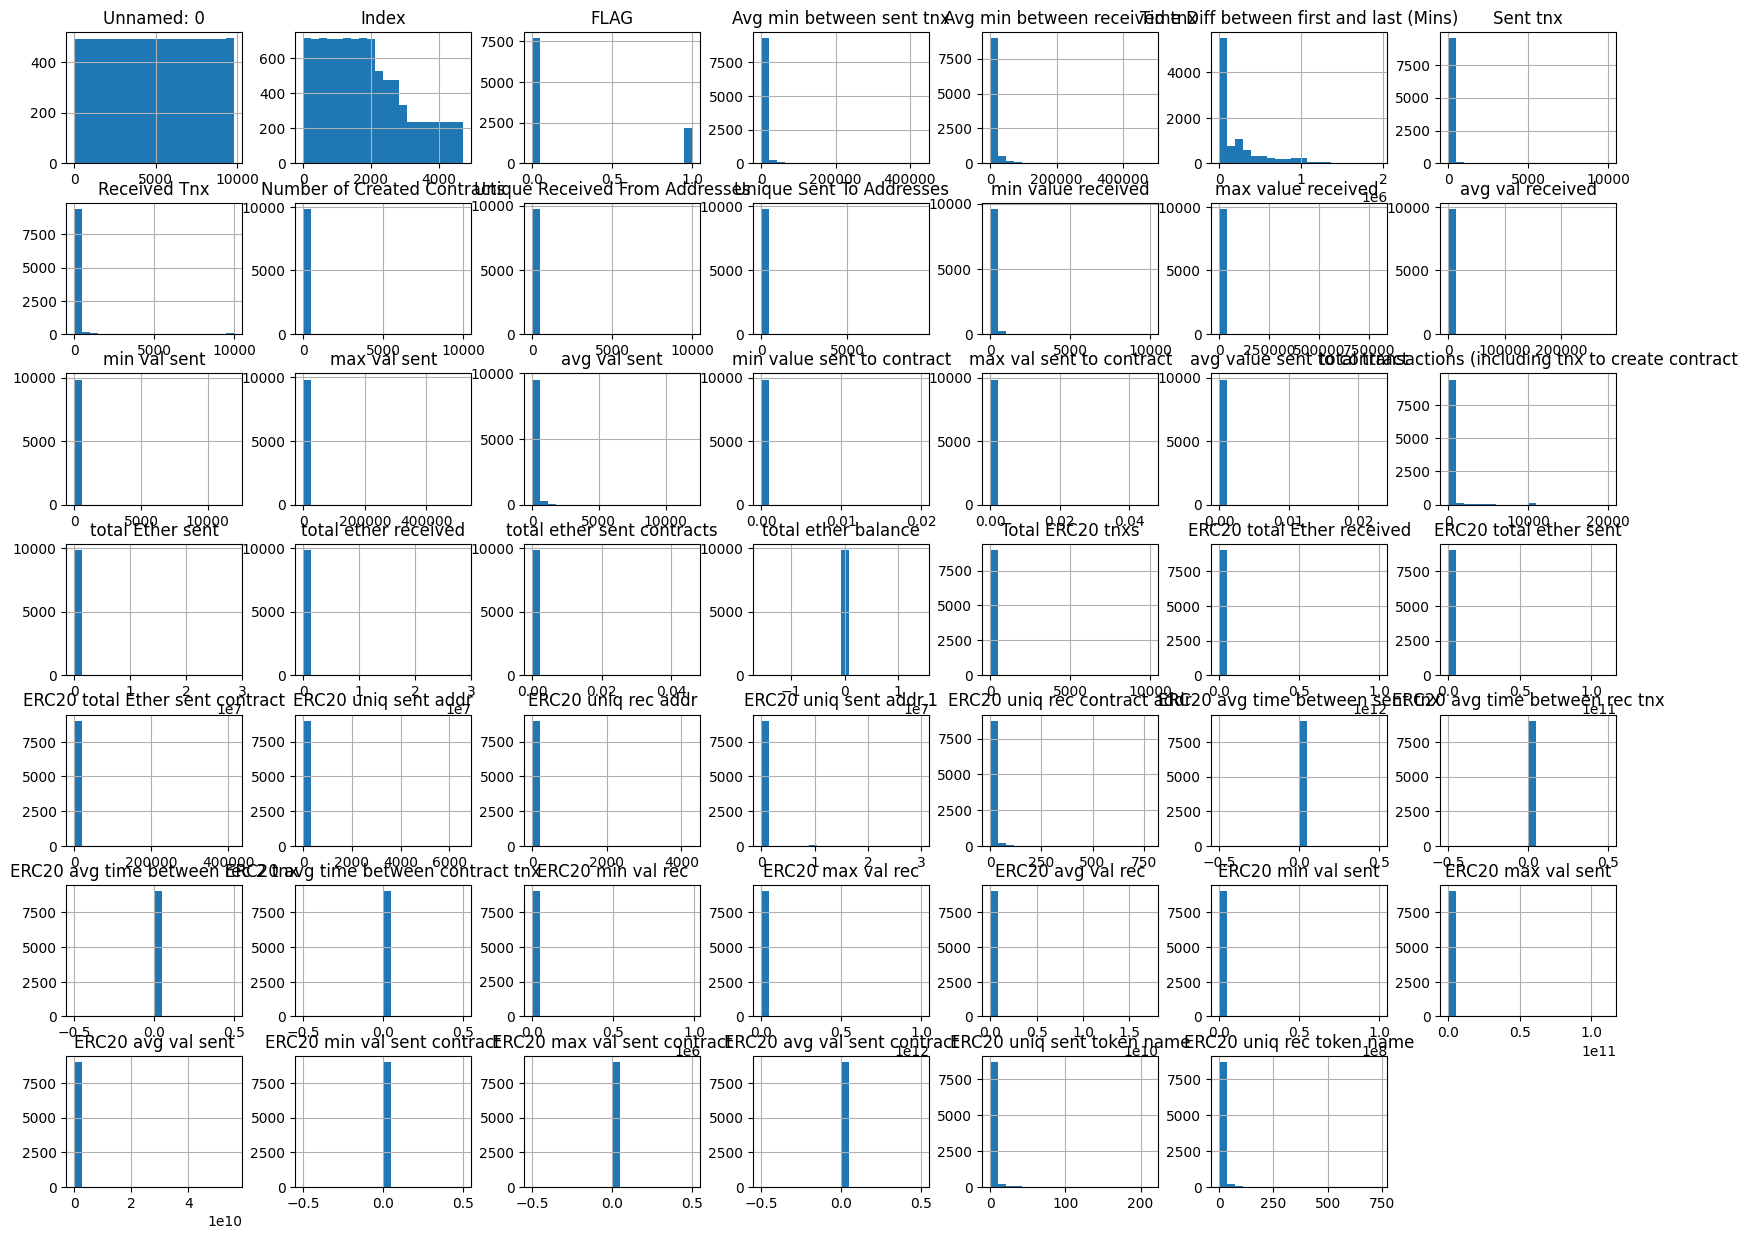

In [56]:
data.hist(bins = 20, figsize = (20, 15))
plt.show()

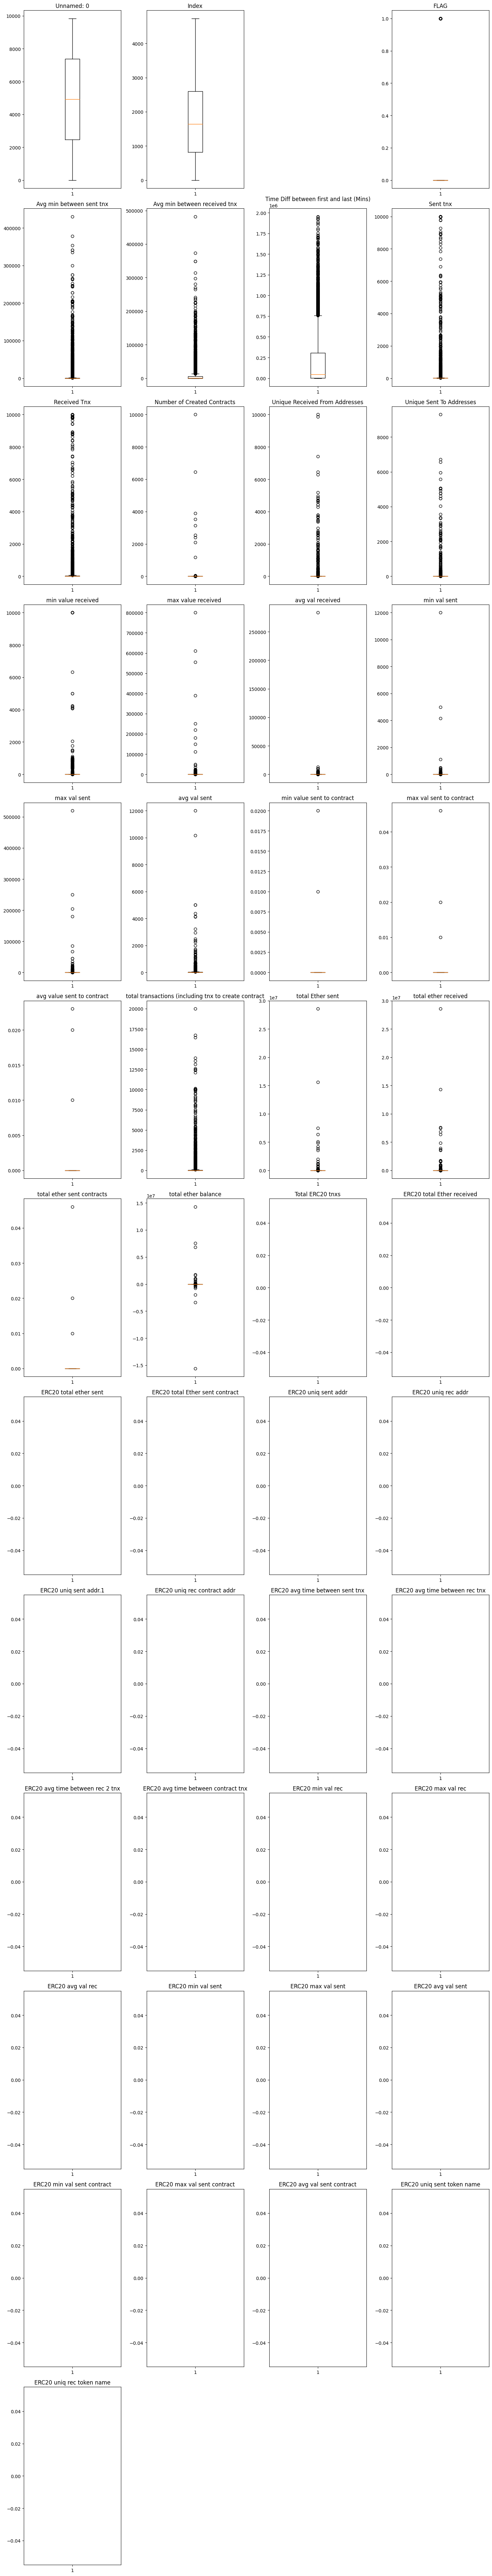

In [57]:
num_cols = 4
num_rows = (len(data.columns) + num_cols - 1) // num_cols

subplot_height = 6

# Oblicz wysokość całej figury
figure_height = subplot_height * num_rows

plt.figure(figsize=(15, figure_height))

for i, column in enumerate(data.columns):
    if pd.api.types.is_numeric_dtype(data[column]):
        plt.subplot(num_rows, num_cols, i + 1)
        
        # Wykres pudełkowy z zaznaczonymi wartościami odstającymi
        plt.boxplot(data[column], showfliers=True)
        
        plt.title(column)

plt.tight_layout()
plt.show()

## Przygotowanie danych

- usunięcie zbędnych kolumn
- usunięcie kolumn z zerową wariancja
- uzupełnienie wartości pustych średnią (numeryczne kolumny)
- usunięcie wysoko skorelowanych kolumn
- uzupełnienie wartości w nienumerycznych kolumnach

In [133]:
data = pd.read_csv('case1.csv', sep=';')

In [134]:
df=data.drop(columns=['Index', 'Address','Unnamed: 0' ], axis = 1)
# df.rename(columns={'Unnamed: 0': 'Index'}, inplace=True)
df.reset_index(drop=True, inplace=True)

In [135]:
df.head()

,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,0,844.26,1093.71,704785.63,721,89,0,40,118,0.000000,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,0,12709.07,2958.44,1218216.73,94,8,0,5,14,0.000000,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,0,246194.54,2434.02,516729.30,2,10,0,10,2,0.113119,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,NaN,XENON
3,0,10219.60,15785.09,397555.90,25,9,0,7,13,0.000000,...,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,0,36.61,10707.77,382472.42,4598,20,1,7,19,0.000000,...,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS


In [136]:
df['ERC20 most sent token type'].value_counts()

ERC20 most sent token type
0                                                         4399
                                                          1191
EOS                                                        138
OmiseGO                                                    137
Golem                                                      130
                                                          ... 
BlockchainPoland                                             1
Covalent Token                                               1
Nebula AI Token                                              1
Blocktix                                                     1
eosDAC Community Owned EOS Block Producer ERC20 Tokens       1
Name: count, Length: 304, dtype: int64

In [137]:
df['ERC20_most_rec_token_type'].value_counts()

ERC20_most_rec_token_type
0                        4399
OmiseGO                   873
Blockwell say NOTSAFU     779
DATAcoin                  358
Livepeer Token            207
                         ... 
BCDN                        1
Egretia                     1
UG Coin                     1
Yun Planet                  1
INS Promo1                  1
Name: count, Length: 466, dtype: int64

### Sprawdzanie wariancji

In [138]:
# wariancja dla numerycznych kolumn
variance_numeric = df[df.columns[:-2]].var()
variance_numeric

FLAG                                                    1.724110e-01
Avg min between sent tnx                                4.616718e+08
Avg min between received tnx                            5.327656e+08
Time Diff between first and last (Mins)                 1.042889e+11
Sent tnx                                                5.733918e+05
Received Tnx                                            8.851734e+05
Number of Created Contracts                             2.000685e+04
Unique Received From Addresses                          8.917457e+04
Unique Sent To Addresses                                6.960121e+04
min value received                                      1.062298e+05
max value received                                      1.692294e+08
avg val received                                        8.323238e+06
min val sent                                            1.921264e+04
max val sent                                            4.394646e+07
avg val sent                      

In [139]:
# Sprawdź, które wariancje są równe 0
no_var = variance_numeric == 0

# Wydrukuj kolumny z wariancją równą 0
no_var

FLAG                                                    False
Avg min between sent tnx                                False
Avg min between received tnx                            False
Time Diff between first and last (Mins)                 False
Sent tnx                                                False
Received Tnx                                            False
Number of Created Contracts                             False
Unique Received From Addresses                          False
Unique Sent To Addresses                                False
min value received                                      False
max value received                                      False
avg val received                                        False
min val sent                                            False
max val sent                                            False
avg val sent                                            False
min value sent to contract                              False
max val 

In [140]:
# Wybierz kolumny do usunięcia
kolumny_do_usunięcia = no_var[no_var].index.tolist()

# Usuń te kolumny z ramki danych
df = df.drop(columns=kolumny_do_usunięcia, axis=1)
# Wydrukuj ramkę danych po usunięciu kolumn
df


,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,...,ERC20 min val rec,ERC20 max val rec,ERC20 avg val rec,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,0,844.26,1093.71,704785.63,721,89,0,40,118,0.000000,...,0.00,1.500000e+07,265586.147600,0.000000,1.683100e+07,271779.920000,39.0,57.0,Cofoundit,Numeraire
1,0,12709.07,2958.44,1218216.73,94,8,0,5,14,0.000000,...,0.00,3.650000e+02,57.632615,2.260809,2.260809e+00,2.260809,1.0,7.0,Livepeer Token,Livepeer Token
2,0,246194.54,2434.02,516729.30,2,10,0,10,2,0.113119,...,0.00,4.428198e+02,65.189009,0.000000,0.000000e+00,0.000000,0.0,8.0,NaN,XENON
3,0,10219.60,15785.09,397555.90,25,9,0,7,13,0.000000,...,0.00,1.141223e+04,1555.550174,100.000000,9.029231e+03,3804.076893,1.0,11.0,Raiden,XENON
4,0,36.61,10707.77,382472.42,4598,20,1,7,19,0.000000,...,0.00,9.000000e+04,4934.232147,0.000000,4.500000e+04,13726.659220,6.0,27.0,StatusNetwork,EOS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9836,1,12635.10,631.39,58748.48,4,13,0,11,4,0.004082,...,0.00,1.337000e+00,0.668500,0.000000,0.000000e+00,0.000000,0.0,2.0,,GSENetwork
9837,1,0.00,0.00,0.00,0,0,0,0,0,0.000000,...,13.37,1.337000e+01,13.370000,0.000000,0.000000e+00,0.000000,0.0,1.0,,Blockwell say NOTSAFU
9838,1,2499.44,2189.29,261601.88,67,43,0,31,44,0.001078,...,0.00,1.500000e+03,300.693901,0.000000,0.000000e+00,0.000000,0.0,5.0,,Free BOB Tokens - BobsRepair.com
9839,1,0.00,0.00,0.00,0,1,0,1,0,0.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Uzupełnienie braków średnią

In [141]:
# wybór numerycznych kolumn
numeric_columns = df.select_dtypes(include=['number'])

# uzupełnieinie braków średnią
numeric_columns.fillna(numeric_columns.mean(), inplace=True)

# złączenie uzupełnionych kolumn z oryginalnymi danymi
df.update(numeric_columns)

In [142]:
df.describe()

,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,...,ERC20 uniq sent addr.1,ERC20 uniq rec contract addr,ERC20 min val rec,ERC20 max val rec,ERC20 avg val rec,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 uniq sent token name,ERC20 uniq rec token name
count,9841.000000,9841.000000,9841.000000,9.841000e+03,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,...,9841.00000,9841.000000,9841.000000,9.841000e+03,9.841000e+03,9.841000e+03,9.841000e+03,9.841000e+03,9841.000000,9841.000000
mean,0.221421,5086.878721,8004.851184,2.183333e+05,115.931714,163.700945,3.729702,30.360939,25.840159,43.845153,...,0.00344,4.901909,485.614688,1.252524e+08,4.346203e+06,1.174126e+04,1.303594e+07,6.318389e+06,1.384931,4.826676
std,0.415224,21486.549974,23081.714801,3.229379e+05,757.226361,940.836550,141.445583,298.621112,263.820410,325.929139,...,0.06287,16.504099,16156.442360,1.008377e+10,2.049013e+08,1.008210e+06,1.129109e+09,5.660130e+08,6.445170,15.960582
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,0.000000,0.000000,0.000000,3.169300e+02,1.000000,1.000000,0.000000,1.000000,1.000000,0.001000,...,0.00000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,0.000000,17.340000,509.770000,4.663703e+04,3.000000,4.000000,0.000000,2.000000,2.000000,0.095856,...,0.00000,1.000000,0.000000,5.356400e-01,4.332520e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.000000
75%,0.000000,565.470000,5480.390000,3.040710e+05,11.000000,27.000000,0.000000,5.000000,3.000000,2.000000,...,0.00000,4.000000,0.519421,6.000000e+02,1.480957e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,4.000000
max,1.000000,430287.670000,482175.490000,1.954861e+06,10000.000000,10000.000000,9995.000000,9999.000000,9287.000000,10000.000000,...,3.00000,782.000000,990000.000000,1.000000e+12,1.724181e+10,1.000000e+08,1.120000e+11,5.614756e+10,213.000000,737.000000


In [143]:
# Kolumna ERC20 most sent token i ERC20_most_rec_token_type nie są numeryczne
df['ERC20 most sent token type'].value_counts()

ERC20 most sent token type
0                                                         4399
                                                          1191
EOS                                                        138
OmiseGO                                                    137
Golem                                                      130
                                                          ... 
BlockchainPoland                                             1
Covalent Token                                               1
Nebula AI Token                                              1
Blocktix                                                     1
eosDAC Community Owned EOS Block Producer ERC20 Tokens       1
Name: count, Length: 304, dtype: int64

In [144]:
df['ERC20_most_rec_token_type'].value_counts()

ERC20_most_rec_token_type
0                        4399
OmiseGO                   873
Blockwell say NOTSAFU     779
DATAcoin                  358
Livepeer Token            207
                         ... 
BCDN                        1
Egretia                     1
UG Coin                     1
Yun Planet                  1
INS Promo1                  1
Name: count, Length: 466, dtype: int64

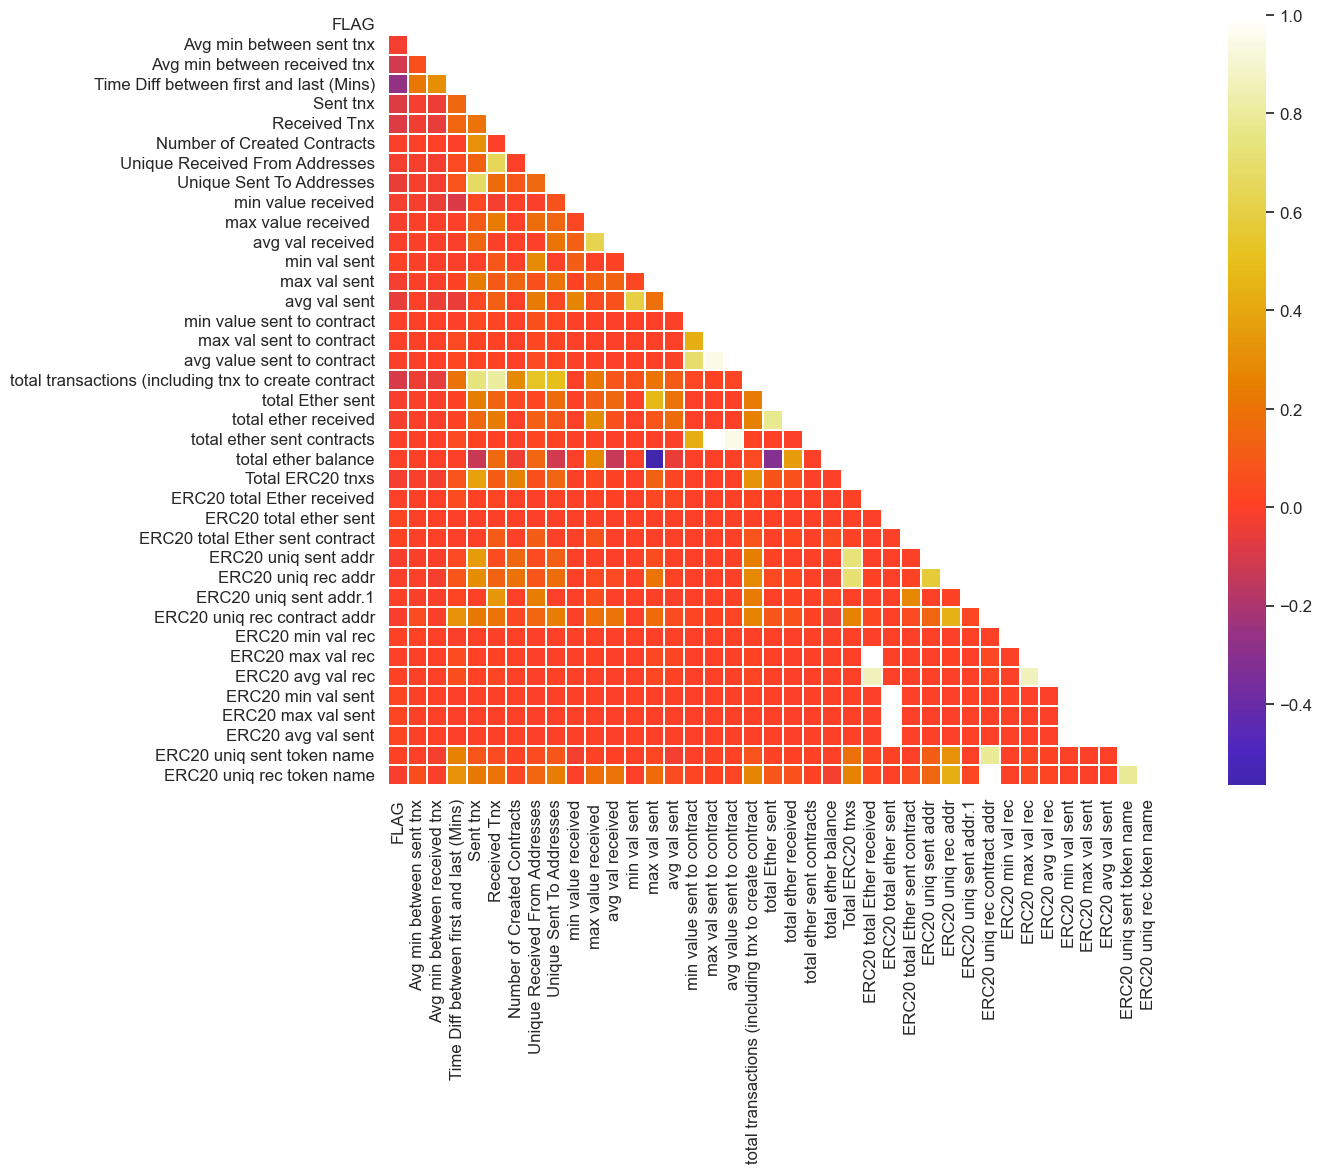

In [145]:
# korelacja
corr = numeric_columns.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(18,10))
    sns.heatmap(corr,  mask=mask, annot=False, cmap='CMRmap', center=0,linewidths=0.1, square=True)

In [146]:
high_corr_pairs = []

# sprawdzanie w macieerzy korelacji, które pary są ze sobą skorelowane powyżej 0,7
for i in range(len(corr.columns)):
    for j in range(i+1, len(corr.columns)): # pomijanie powtarzających się par
        if abs(corr.iloc[i, j]) > 0.7:  
            high_corr_pairs.append((corr.columns[i], corr.columns[j], corr.iloc[i, j]))

for pair in high_corr_pairs:
    print(pair)


('Sent tnx', 'total transactions (including tnx to create contract', 0.7315031286829798)
('Received Tnx', 'total transactions (including tnx to create contract', 0.8063928352729841)
('max val sent to contract', 'avg value sent to contract', 0.9496068530748564)
('max val sent to contract', 'total ether sent contracts', 0.9999999999969983)
('avg value sent to contract', 'total ether sent contracts', 0.9496076212881008)
('total Ether sent', 'total ether received', 0.7749647203903458)
('Total ERC20 tnxs', 'ERC20 uniq sent addr', 0.7259114075626141)
('Total ERC20 tnxs', 'ERC20 uniq rec addr', 0.7171542287295591)
('ERC20 total Ether received', 'ERC20 max val rec', 0.9999665890911656)
('ERC20 total Ether received', 'ERC20 avg val rec', 0.8598224717098503)
('ERC20 total ether sent', 'ERC20 min val sent', 0.9993107519848012)
('ERC20 total ether sent', 'ERC20 max val sent', 0.999649227188527)
('ERC20 total ether sent', 'ERC20 avg val sent', 0.9995659061716186)
('ERC20 uniq rec contract addr', 'E

In [147]:
df.columns

Index(['FLAG', 'Avg min between sent tnx', 'Avg min between received tnx',
       'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx',
       'Number of Created Contracts', 'Unique Received From Addresses',
       'Unique Sent To Addresses', 'min value received', 'max value received ',
       'avg val received', 'min val sent', 'max val sent', 'avg val sent',
       'min value sent to contract', 'max val sent to contract',
       'avg value sent to contract',
       'total transactions (including tnx to create contract',
       'total Ether sent', 'total ether received',
       'total ether sent contracts', 'total ether balance', 'Total ERC20 tnxs',
       'ERC20 total Ether received', 'ERC20 total ether sent',
       'ERC20 total Ether sent contract', 'ERC20 uniq sent addr',
       'ERC20 uniq rec addr', 'ERC20 uniq sent addr.1',
       'ERC20 uniq rec contract addr', 'ERC20 min val rec',
       'ERC20 max val rec', 'ERC20 avg val rec', 'ERC20 min val sent',
       '

In [148]:
columns_to_drop = ['Unique Received From Addresses', 'Unique Sent To Addresses',
                   'ERC20 uniq sent addr', 'ERC20 avg val sent', 'ERC20 max val rec',
                   'ERC20 min val sent', 'ERC20 max val sent', 'ERC20 avg val rec',
                   'max val sent to contract' ,'ERC20 uniq rec contract addr',
                  'avg value sent to contract', 'total transactions (including tnx to create contract',
                  'ERC20 uniq sent token name']
df.drop(columns_to_drop, axis=1, inplace=True)

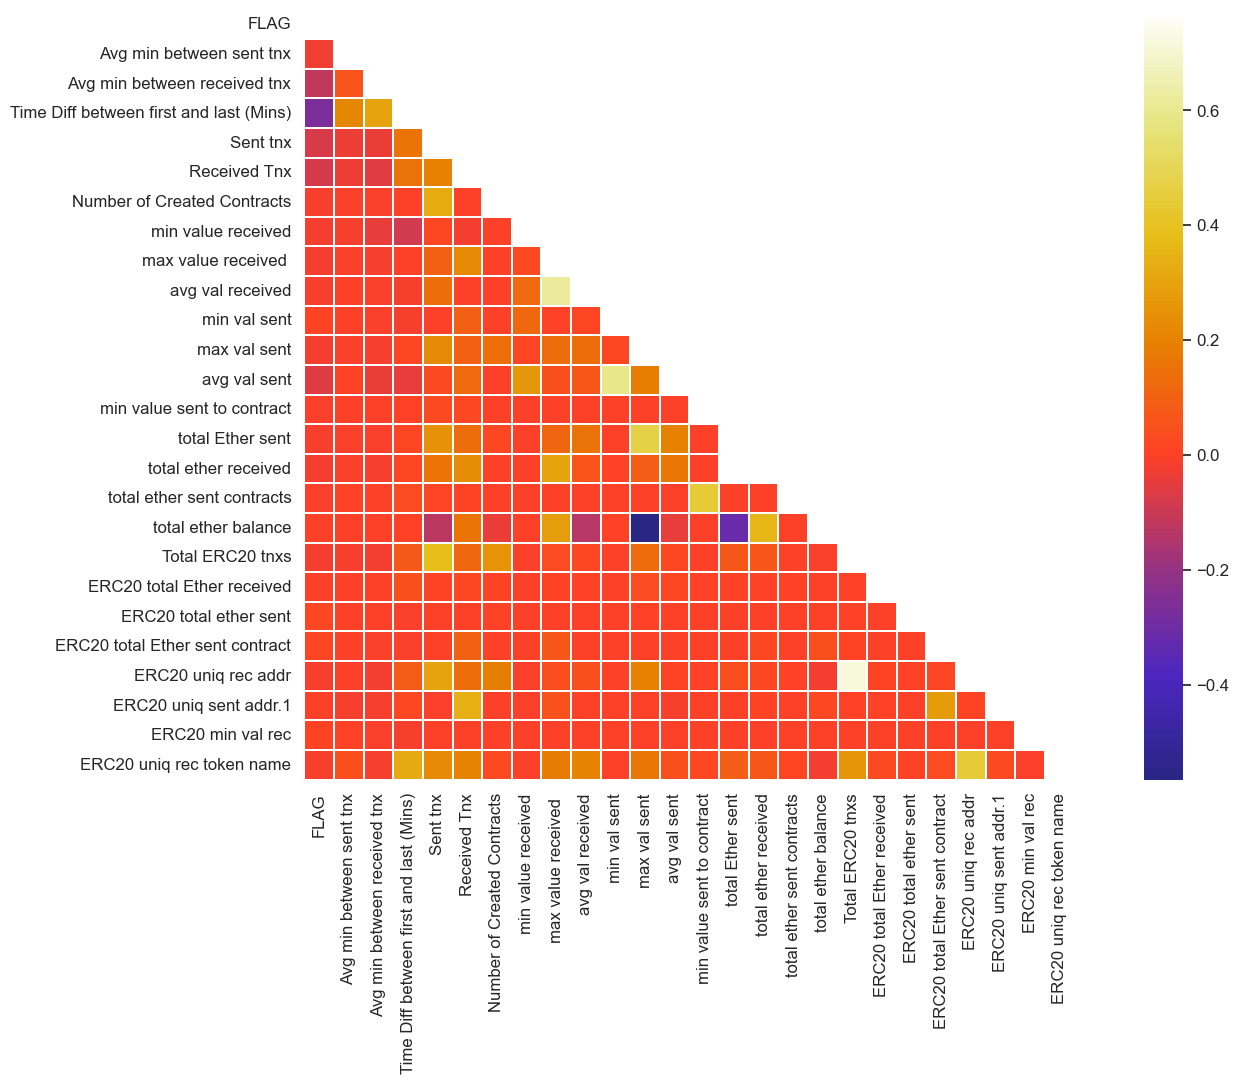

In [149]:
numeric_columns = df.select_dtypes(include=['number'])

# korelacja
corr = numeric_columns.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(18,10))
    sns.heatmap(corr,  mask=mask, annot=False, cmap='CMRmap', center=0,linewidths=0.1, square=True)

In [150]:
high_corr_pairs = []

# sprawdzanie w macieerzy korelacji, które pary są ze sobą skorelowane powyżej 0,7
for i in range(len(corr.columns)):
    for j in range(i+1, len(corr.columns)): # pomijanie powtarzających się par
        if abs(corr.iloc[i, j]) > 0.7:  
            high_corr_pairs.append((corr.columns[i], corr.columns[j], corr.iloc[i, j]))

for pair in high_corr_pairs:
    print(pair)


('total Ether sent', 'total ether received', 0.7749647203903458)
('Total ERC20 tnxs', 'ERC20 uniq rec addr', 0.7171542287295591)


In [151]:
# Uzupełnienie wartości w kolumnach nienumerycznych
for column in ['ERC20 most sent token type', 'ERC20_most_rec_token_type']:
    if df[column].dtype == 'object':
        most_common_value = df[column].mode()[0]
        df[column].fillna(most_common_value, inplace=True)

In [152]:
df.head()

,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,min value received,max value received,avg val received,...,Total ERC20 tnxs,ERC20 total Ether received,ERC20 total ether sent,ERC20 total Ether sent contract,ERC20 uniq rec addr,ERC20 uniq sent addr.1,ERC20 min val rec,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,0,844.26,1093.71,704785.63,721,89,0,0.000000,45.806785,6.589513,...,265.0,3.558854e+07,3.560317e+07,0.0,54.0,0.0,0.0,57.0,Cofoundit,Numeraire
1,0,12709.07,2958.44,1218216.73,94,8,0,0.000000,2.613269,0.385685,...,8.0,4.034283e+02,2.260809e+00,0.0,5.0,0.0,0.0,7.0,Livepeer Token,Livepeer Token
2,0,246194.54,2434.02,516729.30,2,10,0,0.113119,1.165453,0.358906,...,8.0,5.215121e+02,0.000000e+00,0.0,7.0,0.0,0.0,8.0,0,XENON
3,0,10219.60,15785.09,397555.90,25,9,0,0.000000,500.000000,99.488840,...,14.0,1.711105e+04,1.141223e+04,0.0,11.0,0.0,0.0,11.0,Raiden,XENON
4,0,36.61,10707.77,382472.42,4598,20,1,0.000000,12.802411,2.671095,...,42.0,1.628297e+05,1.235399e+05,0.0,23.0,0.0,0.0,27.0,StatusNetwork,EOS


In [153]:
# przekształcenei zmiennych obliektowych na kategorie
categories = df.select_dtypes('O').columns.astype('category')
df[categories]

,ERC20 most sent token type,ERC20_most_rec_token_type
0,Cofoundit,Numeraire
1,Livepeer Token,Livepeer Token
2,0,XENON
3,Raiden,XENON
4,StatusNetwork,EOS
...,...,...
9836,,GSENetwork
9837,,Blockwell say NOTSAFU
9838,,Free BOB Tokens - BobsRepair.com
9839,0,0


## Tworzenie modeli

### Podział zbioru

In [154]:
y = df['FLAG']
X = df.drop(['FLAG'], axis=1)

In [156]:
## TESTY

X_no_cat = X.drop(columns = ['ERC20 most sent token type', 'ERC20_most_rec_token_type'], axis =1)

In [69]:
columns_to_encode = ['ERC20 most sent token type', 'ERC20_most_rec_token_type']

onehot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')

# przkształcenie kolumn
column_transformer = ColumnTransformer([
    ('onehot', onehot_encoder, columns_to_encode)],  
    remainder='passthrough'
)

X_encoded = column_transformer.fit_transform(X)

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.33, random_state=42)

### Pipeline

In [72]:
y_train.value_counts()

FLAG
0    5135
1    1458
Name: count, dtype: int64

In [100]:
over = SMOTE(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.5)
pca = PCA(svd_solver='arpack') 
minmax_scaler = MinMaxScaler()
maxabs_scaler = MaxAbsScaler() # obsluguje macierze rzadkie

sc = StandardScaler()
# pipeline = make_pipeline(column_transformer,minmax_scaler, over, under, pca, model)


In [78]:
# wyświetlanie wyników
def model_result(y_test, y_pred):
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 4))
    sns.set(font_scale=1.1)
    sns.heatmap(cm,  cmap = 'Spectral',  annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    accuracy = round(accuracy_score(y_test, y_pred), 4)
    precision = round(precision_score(y_test, y_pred),4)
    recall = round(recall_score(y_test, y_pred),4)

    print(f'Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}')

## KNN

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2527
           1       0.95      0.94      0.95       721

    accuracy                           0.98      3248
   macro avg       0.97      0.96      0.97      3248
weighted avg       0.98      0.98      0.98      3248

ROC-AUC Score: 0.9631552053357718


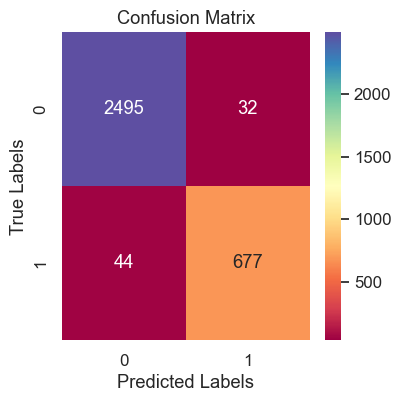

Accuracy: 0.9766
Precision: 0.9549
Recall: 0.939
Cross-Validation ROC-AUC Score: 0.9840133080191737


In [101]:

model_knn = KNeighborsClassifier(n_neighbors=4)

knn_pipeline = make_pipeline(maxabs_scaler, over, under, pca, model_knn)

knn_pipeline.fit(X_train, y_train)

y_pred = knn_pipeline.predict(X_test)

# Ewaluacja modelu
model_result(y_test, y_pred)

# Cross-validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(knn_pipeline, X_encoded, y, scoring='roc_auc', cv=cv, n_jobs=1)
print("Cross-Validation ROC-AUC Score:", scores.mean())


In [ ]:
# # Definicja przestrzeni wyszukiwania hiperparametrów dla KNeighborsClassifier
# param_grid_knn = {
#     'kneighborsclassifier__n_neighbors': list(range(3, 6)),  # Parametr n_neighbors
#     'kneighborsclassifier__metric': ['euclidean', 'manhattan']  # Parametr metric
# }

# # Inicjalizacja BayesSearchCV z potokiem i przestrzenią wyszukiwania hiperparametrów
# search_knn = BayesSearchCV(estimator=knn_pipeline, search_spaces=param_grid_knn, cv=cv)

# # Przeprowadzenie wyszukiwania hiperparametrów
# search_knn.fit(X_train, y_train)

# # Raportowanie najlepszego wyniku i najlepszych parametrów
# print(f'Best score: {search_knn.best_score_}')
# print(f'Best params: {search_knn.best_params_}')

# # Najlepsze parametry KNeighborsClassifier
# knn_best_params = search_knn.best_params_


## RandomForest 

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2527
           1       1.00      0.94      0.97       721

    accuracy                           0.99      3248
   macro avg       0.99      0.97      0.98      3248
weighted avg       0.99      0.99      0.99      3248

ROC-AUC Score: 0.9715672676837726


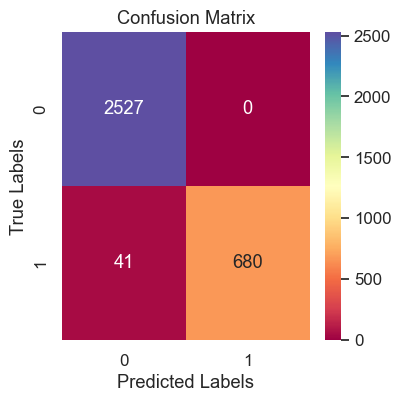

Accuracy: 0.9874
Precision: 1.0
Recall: 0.9431
Cross-Validation ROC-AUC Score: 0.9980638038265902


In [123]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=1)
rf_pipeline = make_pipeline(over, under, pca, rf_model) 
rf_pipeline.fit(X_train, y_train)

rf_y_pred = rf_pipeline.predict(X_test)

model_result(y_test, rf_y_pred)

rf_scores = cross_val_score(rf_pipeline, X_encoded, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print("Cross-Validation ROC-AUC Score:", rf_scores.mean())

In [ ]:
# # Get the RandomForestClassifier model from the pipeline
# rf_model = rf_pipeline.named_steps['randomforestclassifier']

# # Fit the model again to get feature importances
# rf_model.fit(X_train, y_train)

# # Get feature importances
# importances = rf_model.feature_importances_

# # Get indices of features sorted by importance
# indices = np.argsort(importances)[::-1]

# # Get feature names from the pipeline
# feature_names = rf_pipeline.named_steps['pca'].get_feature_names_out()

# # Plot
# plt.figure(figsize=(10, 6))
# plt.title("Feature Importances")
# plt.bar(range(X_train.shape[1]), importances[indices], align="center")
# plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
# plt.xlim([-1, X_train.shape[1]])
# plt.xlabel("Feature")
# plt.ylabel("Importance")
# plt.tight_layout()
# plt.show()

## LogisticRegression

Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      2527
           1       0.99      0.58      0.73       721

    accuracy                           0.90      3248
   macro avg       0.94      0.79      0.84      3248
weighted avg       0.91      0.90      0.89      3248

ROC-AUC Score: 0.7874988954245603


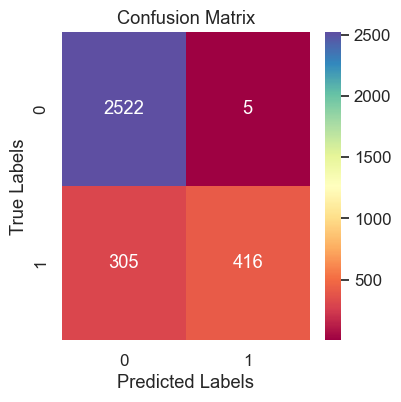

Accuracy: 0.9046
Precision: 0.9881
Recall: 0.577
Cross-Validation ROC-AUC Score: 0.9516884698195965


In [102]:
log_model = LogisticRegression(solver='liblinear', random_state=1)
log_pipeline = make_pipeline(maxabs_scaler, over, under, pca, log_model)
log_pipeline.fit(X_train, y_train)
log_y_pred = log_pipeline.predict(X_test)

model_result(y_test, log_y_pred)

log_scores = cross_val_score(log_pipeline, X_encoded, y, scoring='roc_auc', cv=cv, n_jobs=1)
print("Cross-Validation ROC-AUC Score:", log_scores.mean())

## SVM

Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      2527
           1       0.99      0.57      0.72       721

    accuracy                           0.90      3248
   macro avg       0.94      0.78      0.83      3248
weighted avg       0.91      0.90      0.89      3248

ROC-AUC Score: 0.7842293521232822


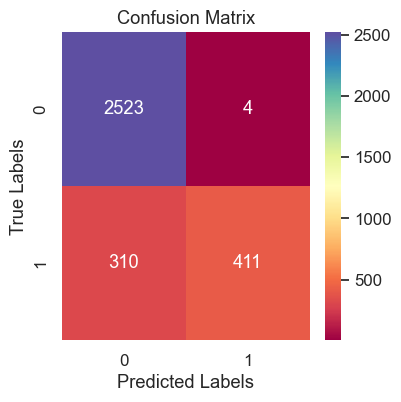

Accuracy: 0.9033
Precision: 0.9904
Recall: 0.57
Cross-Validation ROC-AUC Score: 0.9846616060238841


In [103]:
svm_model = SVC(kernel='rbf', random_state=1)  
svm_pipeline = make_pipeline(maxabs_scaler, over, under, pca, svm_model)
svm_pipeline.fit(X_train, y_train)
svm_y_pred = svm_pipeline.predict(X_test)
model_result(y_test, svm_y_pred)
svm_scores = cross_val_score(svm_pipeline, X_encoded, y, scoring='roc_auc', cv=cv, n_jobs=1)
print("Cross-Validation ROC-AUC Score:", svm_scores.mean())

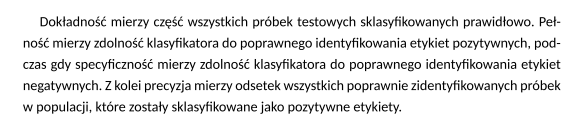
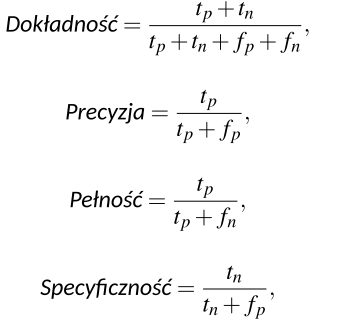

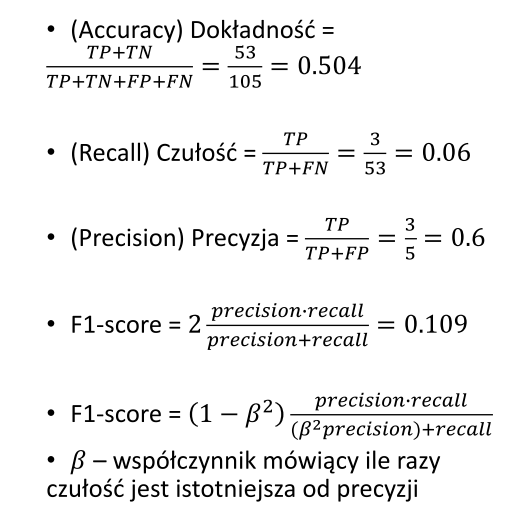

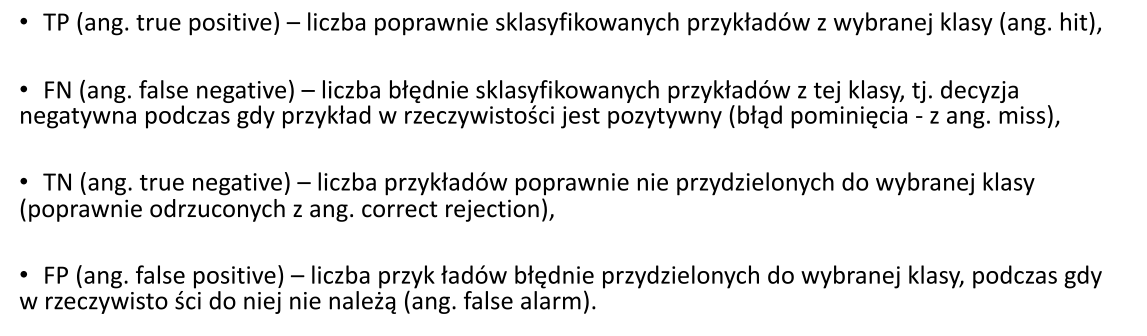

## Bez kolumn 'category'

In [157]:

X_train_no_cat, X_test_no_cat, y_train_no_cat, y_test_no_cat = train_test_split(X_no_cat, y, test_size=0.33, random_state=42)

## KNN

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      2527
           1       0.87      0.83      0.85       721

    accuracy                           0.93      3248
   macro avg       0.91      0.90      0.90      3248
weighted avg       0.93      0.93      0.93      3248

ROC-AUC Score: 0.8957050264906006


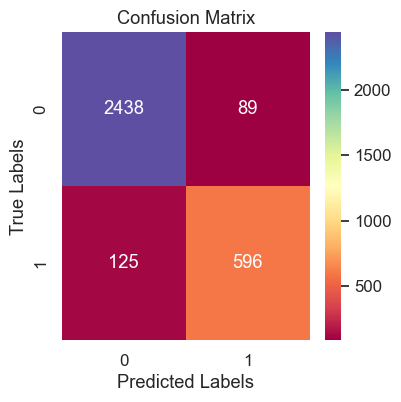

Accuracy: 0.9341
Precision: 0.8701
Recall: 0.8266
Cross-Validation ROC-AUC Score: 0.9479854092842593


In [159]:
model_knn = KNeighborsClassifier(n_neighbors=4)

knn_pipeline = make_pipeline(maxabs_scaler, over, under, pca, model_knn)

knn_pipeline.fit(X_train_no_cat, y_train_no_cat)

y_pred = knn_pipeline.predict(X_test_no_cat)

# Ewaluacja modelu
model_result(y_test_no_cat, y_pred)

# Cross-validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(knn_pipeline, X_no_cat, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print("Cross-Validation ROC-AUC Score:", scores.mean())


## RF

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2527
           1       0.93      0.87      0.90       721

    accuracy                           0.96      3248
   macro avg       0.95      0.93      0.94      3248
weighted avg       0.96      0.96      0.96      3248

ROC-AUC Score: 0.9257110584330013


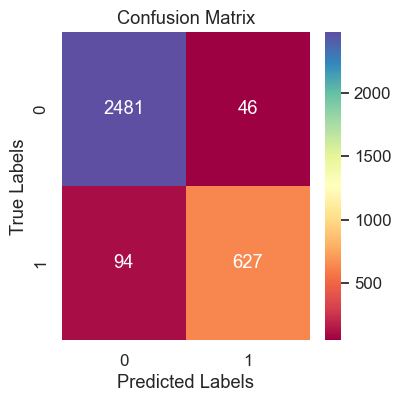

Accuracy: 0.9569
Precision: 0.9316
Recall: 0.8696
Cross-Validation ROC-AUC Score: 0.9914198865589551


In [160]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=1)
rf_pipeline = make_pipeline(over, under, pca, rf_model) 
rf_pipeline.fit(X_train_no_cat, y_train_no_cat)

rf_y_pred = rf_pipeline.predict(X_test_no_cat)

model_result(y_test_no_cat, rf_y_pred)

rf_scores = cross_val_score(rf_pipeline, X_no_cat, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print("Cross-Validation ROC-AUC Score:", rf_scores.mean())

## Log

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88      2527
           1       0.88      0.01      0.02       721

    accuracy                           0.78      3248
   macro avg       0.83      0.50      0.45      3248
weighted avg       0.80      0.78      0.69      3248

ROC-AUC Score: 0.5046565058532894


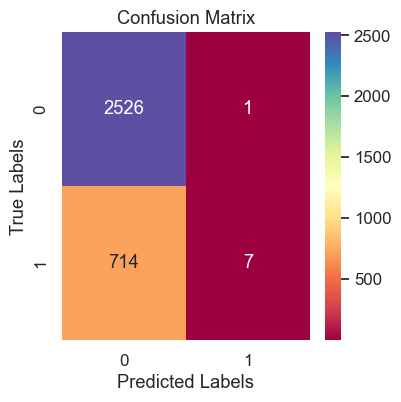

Accuracy: 0.7799
Precision: 0.875
Recall: 0.0097
Cross-Validation ROC-AUC Score: 0.7997548149610608


In [161]:
log_model = LogisticRegression(solver='liblinear', random_state=1)
log_pipeline = make_pipeline(maxabs_scaler, over, under, pca, log_model)
log_pipeline.fit(X_train_no_cat, y_train_no_cat)
log_y_pred = log_pipeline.predict(X_test_no_cat)

model_result(y_test_no_cat, log_y_pred)

log_scores = cross_val_score(log_pipeline, X_no_cat, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print("Cross-Validation ROC-AUC Score:", log_scores.mean())

## SVM

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      2527
           1       0.83      0.44      0.57       721

    accuracy                           0.85      3248
   macro avg       0.84      0.71      0.74      3248
weighted avg       0.85      0.85      0.84      3248

ROC-AUC Score: 0.7050898836257736


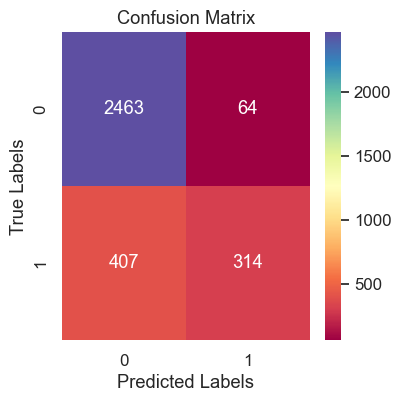

Accuracy: 0.855
Precision: 0.8307
Recall: 0.4355
Cross-Validation ROC-AUC Score: 0.9219439639737234


In [165]:
svm_model = SVC(kernel='rbf', random_state=1)  
svm_pipeline = make_pipeline(maxabs_scaler, over, under, pca, svm_model)
svm_pipeline.fit(X_train_no_cat, y_train_no_cat)
svm_y_pred = svm_pipeline.predict(X_test_no_cat)
model_result(y_test_no_cat, svm_y_pred)
svm_scores = cross_val_score(svm_pipeline, X_no_cat, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print("Cross-Validation ROC-AUC Score:", svm_scores.mean())